In [1]:
# Capstone Project

### Import libraries

In [2]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import ndimage, misc
import tensorflow as tf
import tensorflow_hub as hub

/home/sunit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Function to load images (resize)

In [3]:
def load_images(folder):
#    images = []
#    for filename in os.listdir(folder):
#        if filename.endswith(".jpg"):
#            images.append(filename)
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        resize_img = cv2.resize(img, (299 , 299))
        if resize_img is not None:
            images[filename] = resize_img
    return images

### Load images

In [4]:
train = load_images('train')
train_df = pd.DataFrame(list(train.items()), columns = ('id','pixels'))
for idx,id_ in enumerate(train_df.id):
    train_df.id[idx] = str(id_.split(".")[0])
#train_df.head()

In [5]:
labels = pd.read_csv('labels.csv')
#labels.head()
#labels = labels.drop('id',axis = 1)

In [6]:
data = train_df.merge(labels, on = 'id', how = 'inner')
#data = data.drop('id2', axis=1)

### Data Augmentation

### Salt Pepper

In [7]:
def salt_pepper_aug(data):
    
    pixels = data['pixels'].copy(deep=True)
    breed = data['breed'].copy()
    row, col, lyr = pixels[0].shape
    salt_pepper = 0.2
    amount = 0.005
    salt = np.ceil(amount * pixels[0].size * salt_pepper)
    pepper = np.ceil(amount * pixels[0].size * (1.0 - salt_pepper))
    
    for img in pixels:
        coords = [np.random.randint(0, i - 1, int(salt)) for i in img.shape]
        img[coords[0], coords[1], :] = 1

        coords = [np.random.randint(0, i - 1, int(pepper)) for i in img.shape]
        img[coords[0], coords[1], :] = 0
    aug_data = pixels.to_frame().join(breed.to_frame())
    return aug_data

In [8]:
salt_pepper_noise = salt_pepper_aug(data)

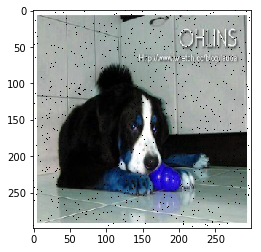

In [9]:
plt.imshow(salt_pepper_noise['pixels'][0])

### Rotation (at 90 degrees):

In [10]:
j=data['pixels'][0]
flip_v=cv2.flip(j,0)  #vertical flipping
flip_h=cv2.flip(j,1)  #horizontal flipping(mirror image)
flip_hv=cv2.flip(j,-1) #vertical and horizontal flipping
r_90=cv2.transpose(j) #rotates by 90 degrees
resized = cv2.resize(j, (500,500), interpolation = cv2.INTER_LINEAR) #scaling up and down

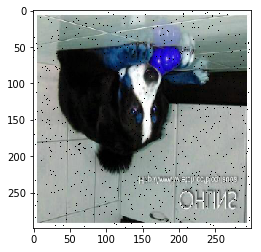

In [12]:
plt.imshow(flip_v)

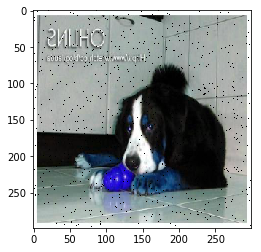

In [13]:
plt.imshow(flip_h)

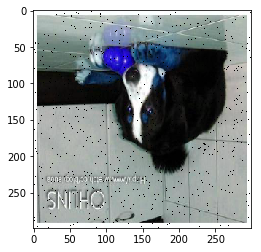

In [14]:
plt.imshow(flip_hv)

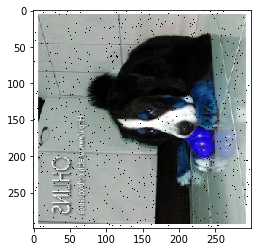

In [15]:
plt.imshow(r_90)

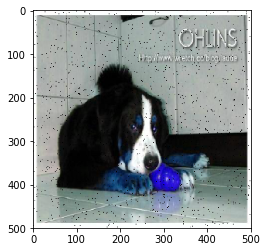

In [16]:
plt.imshow(resized)

# Features

In [17]:
data.head()

,id,pixels,breed
0,f83683931d1c95c7501b11a3edb4acbe,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",bernese_mountain_dog
1,52f8b43baf37bdb02fdbd2ff307f1f58,"[[[30, 58, 38], [25, 64, 43], [37, 87, 69], [3...",mexican_hairless
2,961aab1d30044142287d7ce30c45b65b,"[[[33, 34, 32], [37, 38, 36], [35, 36, 34], [3...",toy_terrier
3,51e9a9481ffe34499d6b251031516a85,"[[[173, 241, 246], [165, 230, 235], [182, 243,...",japanese_spaniel
4,5641d07cac9b01ffd2cd33f75009905c,"[[[59, 42, 45], [0, 0, 0], [20, 5, 9], [26, 12...",walker_hound


In [18]:
data = data.drop('id',axis=1)

In [19]:
dogX = data.iloc[:, :1].copy()

In [21]:
dogY = data.iloc[:, -1:].copy()

In [23]:
dogY_ohe = pd.get_dummies(dogY)

In [24]:
dogY_ohe.head()

,breed_affenpinscher,breed_afghan_hound,breed_african_hunting_dog,breed_airedale,breed_american_staffordshire_terrier,breed_appenzeller,breed_australian_terrier,breed_basenji,breed_basset,breed_beagle,...,breed_toy_poodle,breed_toy_terrier,breed_vizsla,breed_walker_hound,breed_weimaraner,breed_welsh_springer_spaniel,breed_west_highland_white_terrier,breed_whippet,breed_wire-haired_fox_terrier,breed_yorkshire_terrier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
dogX = dogX.pixels

In [27]:
dogX.head()

0    [[[255, 255, 255], [255, 255, 255], [255, 255,...
1    [[[30, 58, 38], [25, 64, 43], [37, 87, 69], [3...
2    [[[33, 34, 32], [37, 38, 36], [35, 36, 34], [3...
3    [[[173, 241, 246], [165, 230, 235], [182, 243,...
4    [[[59, 42, 45], [0, 0, 0], [20, 5, 9], [26, 12...
Name: pixels, dtype: object

In [29]:
module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
height, width = hub.get_expected_image_size(module)

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'.
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'.
INFO:tensorflow:Initialize variable module_1/InceptionV3/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/Inc

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780f

INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module_1/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff421

In [34]:
data_temp = np.zeros((10,299,299,3))

In [35]:
x = tf.placeholder(tf.float32, [10,299,299,3])
y = tf.placeholder(tf.int32, [10,120])

In [36]:
for j in range (10):
    for i in range(data_temp.shape[0]):
        data_temp[i] = dogX[j*10 + i]
    ben_10 = dogY_ohe[j*10: j*10+10].values
    features = module(x)
    fc1 = tf.layers.dense(features, 1024)
    fc2 = tf.layers.dense(fc1, 120)
    sfm = tf.nn.softmax(fc2)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = sfm, labels = y))
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
    train_op = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        loss_arr = sess.run(loss, feed_dict = {x:data_temp, y: ben_10 })
    print(loss_arr)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

4.8005676
4.801278
4.7013435
4.801027
4.801038
4.800769
4.801144
4.8016443
4.800869
4.801225
